In [4]:
import calim
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.patches as mpatches
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
from datetime import datetime
import scipy


n_boot = 10000
seed = 10

In [5]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 300)

In [6]:
color_palette = sns.color_palette("colorblind")
sns.set_theme(palette=color_palette, font="Arial", font_scale=1.0, style="white")


In [7]:
#Calibration of scientifica  Scientifica-Setup (19.05.2021)
kd = 417.1324107961717
R_max = 1.9267297757725788*1.305670312829699
R_min = 0.27585714285714286*0.8222568831620652
sf2_by_sb2 = 2273/413



def calcium(data, kd, R_max, R_min, sf2_by_sb2):
    return kd*((data-R_min)/(R_max-data))*sf2_by_sb2

In [8]:
# Names of used data files

filename_1 = "doppel_perf_fura_data+ctrl_230313.hdf" 

In [9]:
# import data

data_pkl_1 = calim.Project()
data_pkl_1.from_hdf(filename_1)

In [10]:
# Process recordings from data files
# The DataFrame "conditions" will contain all information about conditions
# data is "start corrected"
data_1 = pd.DataFrame()

data_info = pd.DataFrame()

print(f"Processing recordings contained in {filename_1}:")

for recording in data_pkl_1.recordings:
    print(recording)
    
    r = data_pkl_1.recordings[recording]

    info = {desc: r.information[desc] for desc in r.information}
    
    for cell in r.cells:
        c = r.cells[cell]
        
        if c.use:
            
            cell_binned = pd.DataFrame()
            last_frame = 0
          
            for con in r.conditions:
                info["recording"] = recording
                info["start"] = int(con.start)
                info["end"] = int(con.end)
                start = int(con.start)
                end = int(con.end)
                info["cell"] = cell
                info["dt"] = r.dt # Add "dt" aka seconds/frame
                info["date"] = info["recording"][0:6]
                
                info.update({desc: con.information[desc] for desc in con.information}) # Add all further condition variables
                data_info = pd.concat((data_info, pd.DataFrame.from_dict(info,orient='index').T))
                pos_len = (int(con.end) - int(con.start))*r.dt/60
                
                a = np.empty(0)

                if info["pos"] == "1":
                    start = int(end-300/r.dt) #take last 5 min of pos 1
                
                if info["pos"] == "4":
                    if len(c.raw_data[start:end]) < 6000:
                        a = np.empty(6000-len(c.raw_data[start:end]))
                        a[:] = np.nan
                    pos_len = 10
                    end = int(int(con.start) + 600/r.dt)
                calcium_array = np.concatenate((c.raw_data[start:end], a), axis=None)
                    
                binned_Ca = np.average(calcium(calcium_array, 
                                           kd, R_max, R_min, sf2_by_sb2).reshape(-1, 600), axis=1) #bin 1min
                if info["pos"] == "1":
                    binned_Ca = pd.DataFrame(binned_Ca, index=[*np.arange(-4, 1, 1)]) #bin 1min
                else:
                    binned_Ca = pd.DataFrame(binned_Ca, index=[*np.arange(last_frame+1, last_frame+pos_len+1, 1)]) #bin 1min
                    last_frame = last_frame+10
                    
                binned_Ca["pos"] = info["pos"]
                cell_binned = pd.concat((cell_binned, binned_Ca))
            
            cell_binned["cell"] = cell
            cell_binned["recording"] = recording
            cell_binned["animal"] = info["animal"]
            cell_binned["ctrl"] = info["ctrl"]
            cell_binned = cell_binned.reset_index().rename(columns={"index": "bin", 0: "mean_ca"})
            data_1 = pd.concat((data_1, cell_binned), ignore_index=True)

                




print("Done.")
now = datetime.now().strftime("%d-%b-%Y %H:%M")
print("###### date and time ######")
print(now)

Processing recordings contained in doppel_perf_fura_data+ctrl_230313.hdf:
230223_slice03_ttap2_isra_ctrl_results.csv
230223_slice04_ttap2_isra_results.csv
230224_slice01_ttap2_isra_ctrl_results.csv
230224_slice04_ttap2_isra_results.csv
230224_slice06_ttap2_isra_ctrl_results.csv
230227_slice03_ttap2_isra_results.csv
230227_slice04_ttap2_isra_ctrl_results.csv
230228_slice03_ttap2_isra_results.csv
230228_slice04_ttap2_isra_ctrl_results.csv
230302_slice08_ttap2_isra_results.csv
Done.
###### date and time ######
05-May-2023 16:21


In [15]:
data_1.query("pos=='2'").bin.unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [22]:
df_n_animal_rec = pd.concat((data_1.groupby(["ctrl", "pos"]).animal.nunique(), 
           data_1.groupby(["ctrl", "pos"]).recording.nunique()),
         axis=1)
df_n_animal_rec

animal  recording
ctrl pos                   
n    1         5          5
     2         5          5
     3         5          5
     4         5          5
y    1         4          5
     2         4          5
     3         4          5
     4         4          5

In [23]:
data_1[(data_1["pos"]=="1") & (data_1["bin"]==-1)].groupby(["ctrl","animal", "recording", "bin"]).count()#.sum()

mean_ca  pos  \
ctrl animal recording                                  bin                  
n    114002 230224_slice04_ttap2_isra_results.csv      -1.0       39   39   
     11401  230223_slice04_ttap2_isra_results.csv      -1.0       20   20   
     6092   230227_slice03_ttap2_isra_results.csv      -1.0       22   22   
     6093   230302_slice08_ttap2_isra_results.csv      -1.0       16   16   
     6223   230228_slice03_ttap2_isra_results.csv      -1.0       20   20   
y    114001 230223_slice03_ttap2_isra_ctrl_results.csv -1.0       19   19   
     114002 230224_slice01_ttap2_isra_ctrl_results.csv -1.0       28   28   
            230224_slice06_ttap2_isra_ctrl_results.csv -1.0       15   15   
     6092   230227_slice04_ttap2_isra_ctrl_results.csv -1.0        7    7   
     6223   230228_slice04_ttap2_isra_ctrl_results.csv -1.0        4    4   

                                                             cell  
ctrl animal recording                                  bin         
n    114002 230224_slice04_ttap2_isra_results.csv      -1.0    39  
     11401  230223_slice04_ttap2_isra_results.csv      -1.0    20  
     6092   230227_slice03_ttap2_isra_results.csv      -1.0    22  
     6093   230302_slice08_ttap2_isra_results.csv      -1.0    16  
     6223   230228_slice03_ttap2_isra_results.csv      -1.0    20  
y    114001 230223_slice03_ttap2_isra_ctrl_results.csv -1.0    19  
     114002 230224_slice01_ttap2_isra_ctrl_results.csv -1.0    28  
            230224_slice06_ttap2_isra_ctrl_results.csv -1.0    15  
     6092   230227_slice04_ttap2_isra_ctrl_results.csv -1.0     7  
     6223   230228_slice04_ttap2_isra_ctrl_results.csv -1.0     4

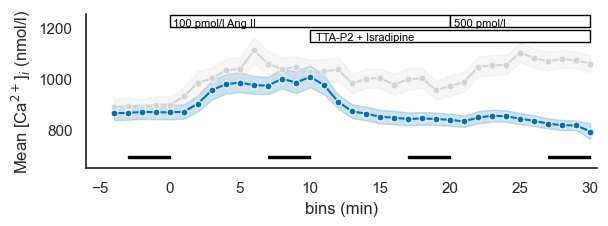

In [24]:
fig1, ax1 = plt.subplots(figsize=(6.6,2))


sns.lineplot(data=data_1[data_1["ctrl"]=="n"], x="bin", y="mean_ca",
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             marker ="o", ms = 5,
                 color=color_palette[0], ax=ax1, zorder=10)

sns.lineplot(data=data_1[data_1["ctrl"]=="y"], x="bin", y="mean_ca",
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             marker ="o", ms = 5,
                 color="lightgrey", ax=ax1, zorder=1)   
    
# Create a Rectangle patch isra/ttap2

ax1.add_patch(plt.Rectangle((0, 1200),20, 48, facecolor='w', linewidth=1, edgecolor = "black", 
                              clip_on=False, zorder=20))
plt.text(0.2, 1205, "100 pmol/l Ang II", ha="left", color="black", zorder=25, size=8) 

ax1.add_patch(plt.Rectangle((20, 1200),10, 48, facecolor='w', linewidth=1, edgecolor = "black", 
                              clip_on=False, zorder=20))
plt.text(20.3, 1205, "500 pmol/l", ha="left", color="black", zorder=25, size=8) 

ax1.add_patch(plt.Rectangle((10, 1140),20, 48, facecolor='w', linewidth=1, edgecolor = "black", 
                              clip_on=False, zorder=20))
plt.text(10.4, 1150, "TTA-P2 + Isradipine", ha="left", color="black", zorder=25, size=8) 

ax1.add_patch(plt.Rectangle((-3,690),3, 6, facecolor='black', linewidth=1, edgecolor = "black", 
                              clip_on=False, zorder=0))
ax1.add_patch(plt.Rectangle((7,690),3, 6, facecolor='black', linewidth=1, edgecolor = "black", 
                              clip_on=False, zorder=0))
ax1.add_patch(plt.Rectangle((17,690),3, 6, facecolor='black', linewidth=1, edgecolor = "black", 
                              clip_on=False, zorder=0))
ax1.add_patch(plt.Rectangle((27,690),3, 6, facecolor='black', linewidth=1, edgecolor = "black", 
                              clip_on=False, zorder=0))

sns.despine(top=True, right=True)

ax1.set_xlabel("bins (min)")
ax1.set_ylabel("Mean [Ca$^{2+}$]$_i$ (nmol/l)")


plt.xlim(-6,30.5)
plt.ylim(650,1250)

plt.show()

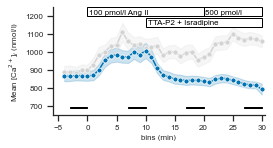

In [17]:
fig1, ax1 = plt.subplots(figsize=(3.8,2))


sns.lineplot(data=data_1[data_1["ctrl"]=="n"], x="bin", y="mean_ca",
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             marker ="o", ms = 5,
                 color=color_palette[0], ax=ax1, zorder=10)

sns.lineplot(data=data_1[data_1["ctrl"]=="y"], x="bin", y="mean_ca",
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             marker ="o", ms = 5,
                 color="lightgrey", ax=ax1, zorder=1)   
    
# Create a Rectangle patch isra/ttap2

ax1.add_patch(plt.Rectangle((0, 1200),20, 48, facecolor='w', linewidth=1, edgecolor = "black", 
                              clip_on=False, zorder=20))
plt.text(0.2, 1205, "100 pmol/l Ang II", ha="left", color="black", zorder=25, size=8) 

ax1.add_patch(plt.Rectangle((20, 1200),10, 48, facecolor='w', linewidth=1, edgecolor = "black", 
                              clip_on=False, zorder=20))
plt.text(20.3, 1205, "500 pmol/l", ha="left", color="black", zorder=25, size=8) 

ax1.add_patch(plt.Rectangle((10, 1140),20, 48, facecolor='w', linewidth=1, edgecolor = "black", 
                              clip_on=False, zorder=20))
plt.text(10.4, 1150, "TTA-P2 + Isradipine", ha="left", color="black", zorder=25, size=8) 

ax1.add_patch(plt.Rectangle((-3,690),3, 6, facecolor='black', linewidth=1, edgecolor = "black", 
                              clip_on=False, zorder=0))
ax1.add_patch(plt.Rectangle((7,690),3, 6, facecolor='black', linewidth=1, edgecolor = "black", 
                              clip_on=False, zorder=0))
ax1.add_patch(plt.Rectangle((17,690),3, 6, facecolor='black', linewidth=1, edgecolor = "black", 
                              clip_on=False, zorder=0))
ax1.add_patch(plt.Rectangle((27,690),3, 6, facecolor='black', linewidth=1, edgecolor = "black", 
                              clip_on=False, zorder=0))

sns.despine(top=True, right=True)

ax1.set_xlabel("bins (min)")
ax1.set_ylabel("Mean [Ca$^{2+}$]$_i$ (nmol/l)")


plt.xlim(-6,30.5)
plt.ylim(650,1250)



plt.savefig("fura_isra_ttap2_100pM_AngII_meanCa_overtime_v2.svg",  bbox_inches='tight')
plt.savefig("fura_isra_ttap2_100pM_AngII_meanCa_overtime_v2.png", dpi=400,  bbox_inches='tight')
plt.show()

In [25]:
#calculate ci 95%
data_long = data_1[data_1["ctrl"]=="n"]

var = ["mean_ca"]
pos = data_long["bin"].unique()
ci_df_wt = pd.DataFrame()
for p in pos:
    ci_df = pd.DataFrame()
    for v in var:
        vals = data_long[(data_long["bin"]==p)].dropna(subset=[v])[v].values
        if vals.size > 0:
            res = scipy.stats.bootstrap((vals,),
                                        np.mean,
                                        confidence_level=0.95,
                                        n_resamples=int(n_boot),
                                        random_state=int(seed),
                                       method="percentile")
            #print(res.confidence_interval)
            ci_l, ci_u = res.confidence_interval

        else:
            ci_l = np.nan
            ci_u = np.nan

        ci_lower = pd.Series(data=ci_l, index=[p], name=f"{v}_ci95_lower")
        ci_upper = pd.Series(data=ci_u, index=[p], name=f"{v}_ci95_upper")

        mean_ca = pd.Series(data=data_long[(data_long["bin"]==p)][v].mean(),
                            index=[p], name="mean_ca")
                           
        ci_df = pd.concat((ci_df, mean_ca, ci_lower, ci_upper), axis=1)
        ci_df.index = [p]
    ci_df_wt = pd.concat((ci_df_wt, ci_df), axis=0)


In [26]:
#calculate ci 95%
data_long = data_1[data_1["ctrl"]=="y"]

var = ["mean_ca"]
pos = data_long["bin"].unique()
ci_df_wt_ctrl = pd.DataFrame()
for p in pos:
    ci_df = pd.DataFrame()
    for v in var:
        vals = data_long[(data_long["bin"]==p)].dropna(subset=[v])[v].values
        if vals.size > 0:
            res = scipy.stats.bootstrap((vals,),
                                        np.mean,
                                        confidence_level=0.95,
                                        n_resamples=int(n_boot),
                                        random_state=int(seed),
                                       method="percentile")
            #print(res.confidence_interval)
            ci_l, ci_u = res.confidence_interval

        else:
            ci_l = np.nan
            ci_u = np.nan

        ci_lower = pd.Series(data=ci_l, index=[p], name=f"{v}_ci95_lower")
        ci_upper = pd.Series(data=ci_u, index=[p], name=f"{v}_ci95_upper")

        mean_ca = pd.Series(data=data_long[(data_long["bin"]==p)][v].mean(),
                            index=[p], name="mean_ca")
                           
        ci_df = pd.concat((ci_df, mean_ca, ci_lower, ci_upper), axis=1)
        ci_df.index = [p]
    ci_df_wt_ctrl = pd.concat((ci_df_wt_ctrl, ci_df), axis=0)
